In [1]:
import os
import yaml
import blip
import torch
import argparse
import torch.nn.functional as F

import seaborn as sns
from matplotlib import pyplot as plt
from data.loaders import CxrDataLoader
from utils.transforms import TransformBuilder

In [2]:
CHECKPOINT_PATH = './output/pretrain'
# MODEL_PATH = os.path.join(CHECKPOINT_PATH, 'checkpoint-14000.pt')
MODEL_PATH = os.path.join(CHECKPOINT_PATH, 'blip_cxr_pretrain_test_split_best_retrieval.pt')

config_path = '../configs/baselines/pretrain.yaml'
pretrain_config = yaml.load(open(config_path), Loader=yaml.Loader)

args = argparse.Namespace(
    dataset_name='mimic-cxr',
    batch_size=10,
    num_workers=0,
    drop_last=True,
    use_minio=False
)

In [3]:
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
# model_keys = checkpoint['model_state_dict']
print(checkpoint.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'global_step', 'epoch', 'best_val_loss', 'best_val_r_mean'])


In [4]:
print(checkpoint['best_val_r_mean'])
print(checkpoint['best_val_loss'])
print(checkpoint['global_step'])

55.16203703703704
5.440605205959744
2430


In [3]:
model = blip.blip_pretrain(
    pretrained=MODEL_PATH,
    use_custom=True,
    image_size=pretrain_config['image_size'],
    vit=pretrain_config['vit'],
    vit_grad_ckpt=pretrain_config['vit_grad_ckpt'],
    vit_ckpt_layer=pretrain_config['vit_ckpt_layer'],
    queue_size=pretrain_config['queue_size'],
    max_length=pretrain_config['max_length'],
)

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

/embeddings/word_embeddings is tied
/embeddings/position_embeddings is tied
/embeddings/LayerNorm is tied
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
/encoder/layer/2/crossattention/self/query is tied
/encoder/layer/2/crossattention/self/key is tied
/encoder/layer/2/crossat

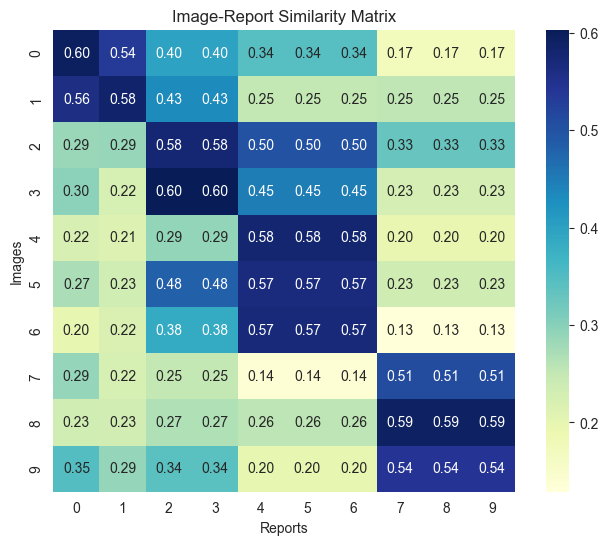

In [4]:
# Model best retrieval
transform = TransformBuilder(image_size=pretrain_config['image_size'])
dataloader = CxrDataLoader(args, split='test', transform=transform.build('test'))

batch = next(iter(dataloader))

reports, images = batch['report'], batch['image']
images = images.cpu()
reports = list(reports)

model.eval()
with torch.no_grad():
    image_embeds = model.visual_encoder(images)
    image_feat = F.normalize(model.vision_proj(image_embeds[:, 0, :]), dim=-1)

    text = model.tokenizer(reports, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
    text_output = model.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True, mode='text')
    text_feat = F.normalize(model.text_proj(text_output.last_hidden_state[:, 0, :]), dim=-1)

similarity = image_feat @ text_feat.T
sim = similarity.detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(sim, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, square=True)
plt.title('Image-Report Similarity Matrix')
plt.xlabel('Reports')
plt.ylabel('Images')
plt.show()

In [5]:
image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long)

with torch.no_grad():
    output = model.text_encoder(
        text.input_ids,
        attention_mask=text.attention_mask,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_atts,
        return_dict=True,
    )
    vl_embeddings = output.last_hidden_state[:, 0, :]  # CLS token output
    itm_logits = model.itm_head(vl_embeddings)  # [batch_size, 2] for match/non-match

    probs = torch.softmax(itm_logits, dim=-1)

print("ITM match probability for each pair:")
print(probs[:,1].cpu().numpy())  # [:,1] gives match probability

ITM match probability for each pair:
[0.34139818 0.3505136  0.34375998 0.32568264 0.3277992  0.32229456
 0.320529   0.33360294 0.32002532 0.33779788]


In [7]:
img = images[0].unsqueeze(0)

with torch.no_grad():
    img_embeds = model.visual_encoder(img)
    img_atts = torch.ones(img_embeds.size()[:-1], dtype=torch.long).to(img.device)

    generated_ids = model.text_decoder.generate(
        input_ids=None,
        encoder_hidden_states=img_embeds,
        encoder_attention_mask=img_atts,
        max_length=50,
        num_beams=3,
        eos_token_id=model.tokenizer.eos_token_id,
        pad_token_id=model.tokenizer.pad_token_id,
        bos_token_id=model.tokenizer.bos_token_id,
    )

    generated_text = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Original Report:")
print(reports[0])

print("Generated Caption:")
print(generated_text)

Original Report:
There is a cardiomediastinal silhouette, position of the NG tube, vascular stents projecting over the left upper mediastinum as well as interstitial opacities and pleural calcifications. AP chest: Upper enteric drainage tube ends in the distal duodenum.
Generated Caption:
there is enlargement of the cardiac silhouette with tortuosity of the aorta and mild elevation of pulmonary venous pressure. there is enlargement of the cardiac silhouette with tortuosity of the aorta and mild elevation of pulmonary venous pressure. there is enlargement of the


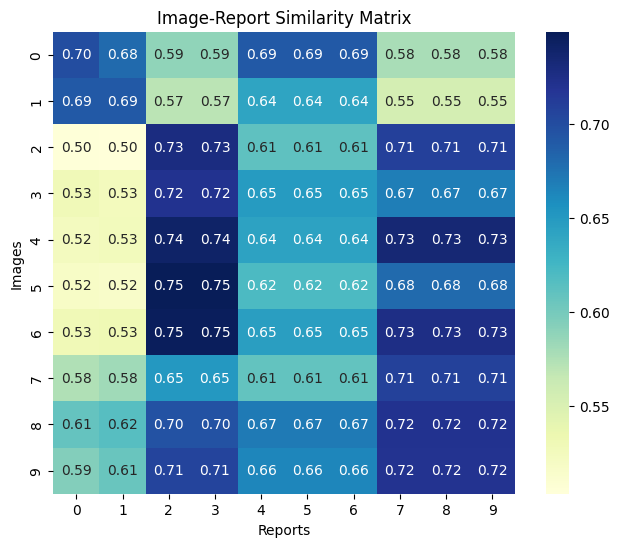

In [29]:
# Checkpoint-140000.pt
transform = TransformBuilder(image_size=pretrain_config['image_size'])
dataloader = CxrDataLoader(args, split='test', transform=transform.build('test'))

batch = next(iter(dataloader))

reports, images = batch['report'], batch['image']
images = images.cpu()
reports = list(reports)

model.eval()
with torch.no_grad():
    image_embeds = model.visual_encoder(images)
    image_feat = F.normalize(model.vision_proj(image_embeds[:, 0, :]), dim=-1)

    text = model.tokenizer(reports, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
    text_output = model.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True, mode='text')
    text_feat = F.normalize(model.text_proj(text_output.last_hidden_state[:, 0, :]), dim=-1)

similarity = image_feat @ text_feat.T
sim = similarity.detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(sim, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, square=True)
plt.title('Image-Report Similarity Matrix')
plt.xlabel('Reports')
plt.ylabel('Images')
plt.show()

In [22]:
image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long)

with torch.no_grad():
    output = model.text_encoder(
        text.input_ids,
        attention_mask=text.attention_mask,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_atts,
        return_dict=True,
    )
    vl_embeddings = output.last_hidden_state[:, 0, :]  # CLS token output
    itm_logits = model.itm_head(vl_embeddings)  # [batch_size, 2] for match/non-match

    probs = torch.softmax(itm_logits, dim=-1)

print("ITM match probability for each pair:")
print(probs[:,1].cpu().numpy())  # [:,1] gives match probability

ITM match probability for each pair:
[0.40187475 0.35831827 0.31498754 0.3499961  0.27274922 0.28043237
 0.26485503 0.27096325 0.3044284  0.31669858]


In [27]:
img = images[0].unsqueeze(0)

with torch.no_grad():
    img_embeds = model.visual_encoder(img)
    img_atts = torch.ones(img_embeds.size()[:-1], dtype=torch.long).to(img.device)

    generated_ids = model.text_decoder.generate(
        input_ids=None,
        encoder_hidden_states=img_embeds,
        encoder_attention_mask=img_atts,
        max_length=128,
        num_beams=3,
        eos_token_id=model.tokenizer.eos_token_id,
        pad_token_id=model.tokenizer.pad_token_id,
        bos_token_id=model.tokenizer.bos_token_id,
    )

    generated_text = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Generated Caption:")
print(generated_text)

Generated Caption:
as compared to the previous radiograph, the patient has received a nasogastric tube. the course of the tube is unremark. the tube is unremarkable
